***Dataset is taken from:***

https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data?resource=download

***REFERENCES***

* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

* https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

* https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

### Multivariate MultiStep Time Series Forecasting Implementation

In [1]:
# import required libraries

# data preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest

# visualization
from matplotlib import pyplot as plt

# implementing deep learning model
import tensorflow as ts
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
data_train = pd.read_csv("archive\DailyDelhiClimateTrain.csv")
data_test = pd.read_csv("archive\DailyDelhiClimateTest.csv")
print("Train Dataframe")
display(data_train.head())
print("Test Dataframe")
display(data_test.head())

Train Dataframe


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


Test Dataframe


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [3]:
# set index of dataframe as date column
data_train.set_index("date",drop=True,inplace=True)
data_test.set_index("date",drop=True,inplace=True)

In [4]:
# dataframe info ---> no Nan values
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5+ KB
None


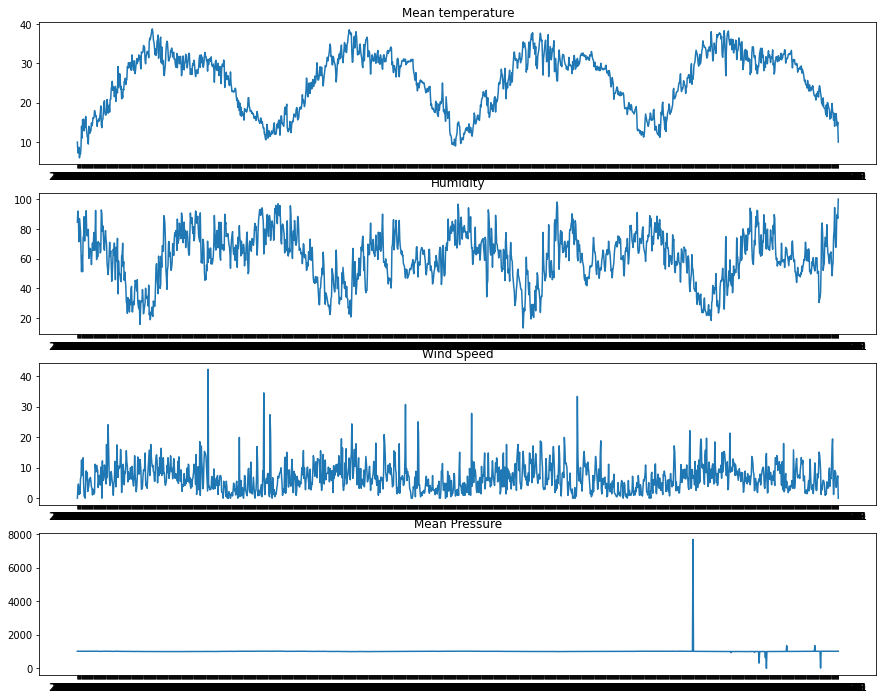

In [5]:
# print the feature graphs
plt.figure(figsize=(15,12))
plt.subplot(4,1,1)
plt.title("Mean temperature")
plt.plot(data_train["meantemp"])

plt.subplot(4,1,2)
plt.title("Humidity")
plt.plot(data_train["humidity"])

plt.subplot(4,1,3)
plt.title("Wind Speed")
plt.plot(data_train["wind_speed"])

plt.subplot(4,1,4)
plt.title("Mean Pressure")
plt.plot(data_train["meanpressure"])

plt.show()

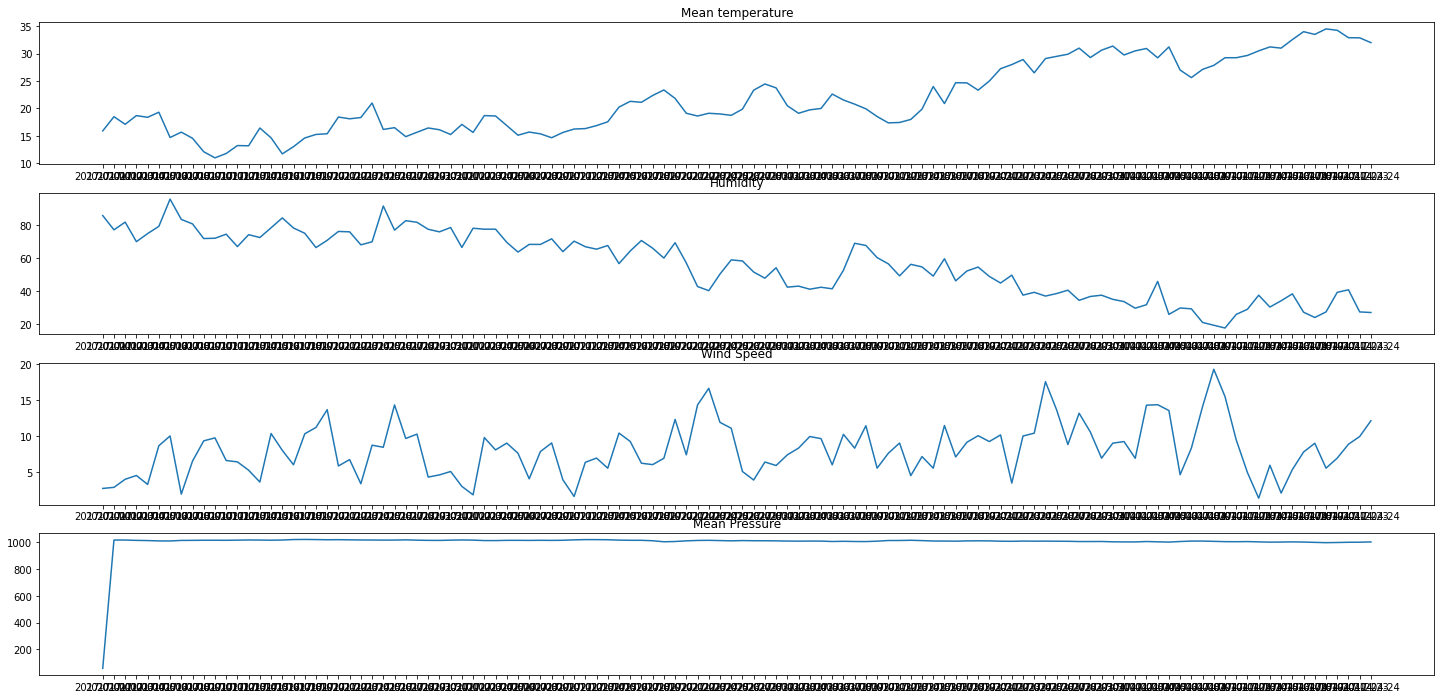

In [6]:
# print the feature graphs
plt.figure(figsize=(25,12))
plt.subplot(4,1,1)
plt.title("Mean temperature")
plt.plot(data_test["meantemp"])

plt.subplot(4,1,2)
plt.title("Humidity")
plt.plot(data_test["humidity"])

plt.subplot(4,1,3)
plt.title("Wind Speed")
plt.plot(data_test["wind_speed"])

plt.subplot(4,1,4)
plt.title("Mean Pressure")
plt.plot(data_test["meanpressure"])

plt.show()

In [7]:
def scaled_transform(X,min_data, max_data, min_range=-1, max_range=1):
    X_std = (X-min_data)/(max_data-min_data)
    X_sc = X_std * (max_range - min_range) + (min_range)
    return np.array(X_sc)

In [8]:
def inverse_transform(X_scaled,min_data,max_data,min_range=-1,max_range=1):
    X_std = (X_scaled - (min_range))/(max_range-min_range)
    X = X_std * (max_data - min_data) + min_data
    return X

In [9]:
# scale the data
# scaler_tr = MinMaxScaler(feature_range=(-1,1)).fit(data_train)
# data_tr_sc = scaler_tr.transform(data_train)

# scaler_ts = MinMaxScaler(feature_range=(-1,1)).fit(data_test)
# data_ts_sc = scaler_ts.transform(data_test)
data_tr_sc = pd.DataFrame()
data_ts_sc = pd.DataFrame()

tr0_min = data_train["meantemp"].values.min()
tr0_max = data_train["meantemp"].values.max()
tr1_min = data_train["humidity"].values.min()
tr1_max = data_train["humidity"].values.max()
tr2_min = data_train["wind_speed"].values.min()
tr2_max = data_train["wind_speed"].values.max()
tr3_min = data_train["meanpressure"].values.min()
tr3_max = data_train["meanpressure"].values.max()
print(tr3_min,tr3_max)


data_tr_sc["meantemp"] = scaled_transform(data_train["meantemp"].values,tr0_min,tr0_max)
data_tr_sc["humidity"] = scaled_transform(data_train["humidity"].values,tr1_min,tr1_max)
data_tr_sc["wind_speed"] = scaled_transform(data_train["wind_speed"].values,tr2_min,tr2_max)
data_tr_sc["meanpressure"] = scaled_transform(data_train["meanpressure"].values,tr3_min,tr3_max)

ts0_min = data_test["meantemp"].values.min()
ts0_max = data_test["meantemp"].values.max()
ts1_min = data_test["humidity"].values.min()
ts1_max = data_test["humidity"].values.max()
ts2_min = data_test["wind_speed"].values.min()
ts2_max = data_test["wind_speed"].values.max()
ts3_min = data_test["meanpressure"].values.min()
ts3_max = data_test["meanpressure"].values.max()

data_ts_sc["meantemp"] = scaled_transform(data_test["meantemp"].values,ts0_min,ts0_max)
data_ts_sc["humidity"] = scaled_transform(data_test["humidity"].values,ts1_min,ts1_max)
data_ts_sc["wind_speed"] = scaled_transform(data_test["wind_speed"].values,ts2_min,ts2_max)
data_ts_sc["meanpressure"] = scaled_transform(data_test["meanpressure"].values,ts3_min,ts3_max)

data_tr_sc = np.array(data_tr_sc) 
data_ts_sc = np.array(data_ts_sc) 

-3.0416666666666665 7679.333333333333


In [10]:
display(data_tr_sc[:,3])
# display(data_ts_sc)

array([-0.73479339, -0.734238  , -0.73401238, ..., -0.73421073,
       -0.73468057, -0.73470661])

In [11]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

[6, 18, 19, 20, 21, 22, 23, 24, 25, 143, 159, 160, 166, 167, 168, 171, 172, 173, 174, 177, 178, 179, 181, 182, 190, 198, 199, 201, 205, 206, 210, 211, 215, 356, 357, 358, 364, 365, 366, 375, 376, 379, 380, 382, 383, 384, 385, 386, 387, 389, 396, 520, 521, 522, 523, 524, 525, 526, 531, 532, 533, 534, 535, 536, 537, 538, 539, 554, 556, 557, 560, 562, 563, 564, 566, 579, 580, 715, 716, 717, 722, 723, 726, 733, 738, 741, 749, 750, 751, 752, 753, 754, 755, 758, 759, 763, 764, 769, 770, 797, 872, 899, 902, 903, 904, 905, 906, 915, 925, 926, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1094, 1095, 1096, 1115, 1116, 1117, 1141, 1182, 1236, 1237, 1255, 1261, 1281, 1286, 1300, 1309, 1321, 1323, 1362, 1416, 1427, 1433]
139
139


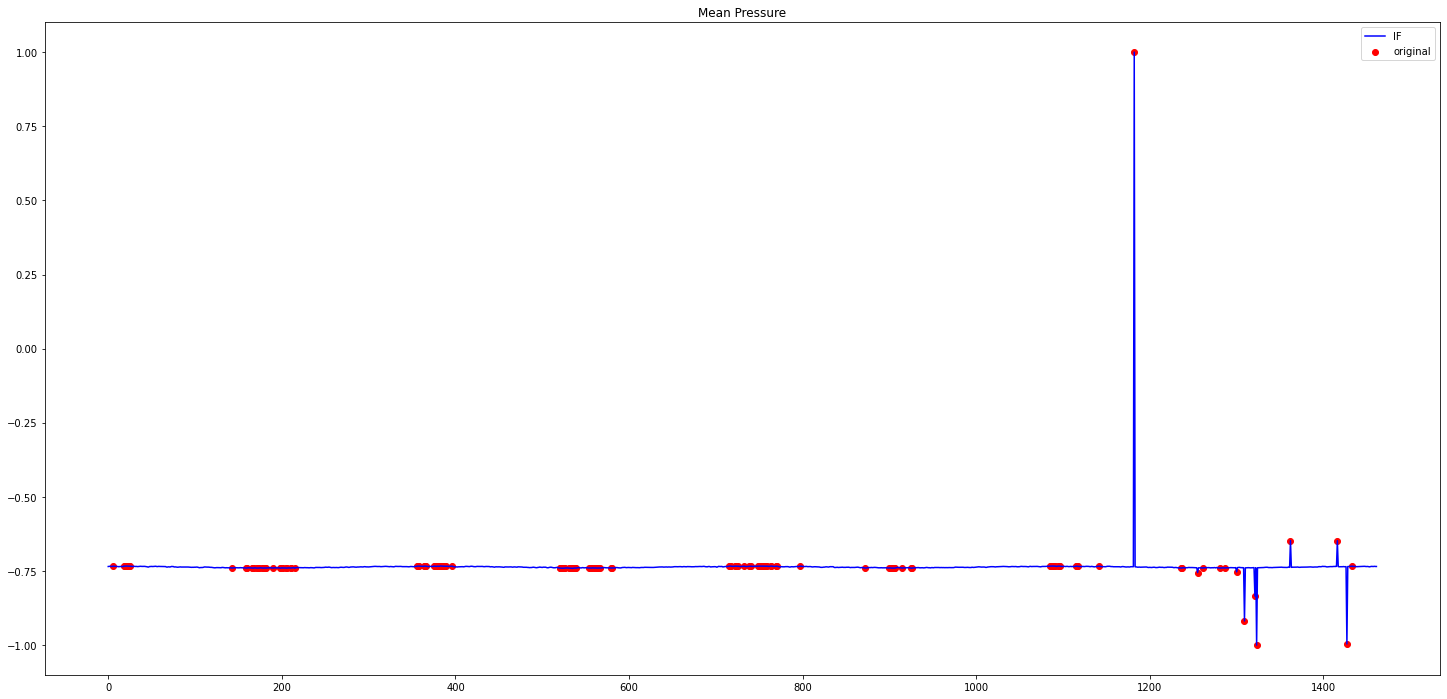

In [12]:
isolation_forest = IsolationForest()
plt.figure(figsize=(25,12))


# mean preassure feature

dt_tr3 = [[item] for item in data_tr_sc[:,3]]

isolation_forest.fit(dt_tr3)
anomaly = isolation_forest.predict(dt_tr3)
res_list = [i for i in range(len(anomaly)) if anomaly[i] == -1]
print(res_list)
plt.title("Mean Pressure")
plt.plot(dt_tr3,color='blue')

anomaly_val = []
for i in range(len(res_list)):
    anomaly_val.append(data_tr_sc[:,3][res_list[i]])
print(len(res_list))
print(len(anomaly_val))
plt.scatter(res_list[:1000],anomaly_val[:1000],color='r')
plt.legend(['IF', 'original'], loc='upper right')
plt.show()


[0, 3, 5, 11, 13, 14, 15, 29, 32, 47, 56, 58, 59, 60, 69, 76, 83, 84, 94, 110, 116, 117, 130, 137, 138, 141, 142, 151, 152, 158, 161, 165, 174, 179, 185, 195, 228, 229, 235, 236, 238, 244, 245, 246, 247, 251, 270, 279, 280, 285, 288, 289, 290, 292, 293, 294, 295, 296, 298, 304, 308, 311, 312, 315, 318, 319, 325, 326, 334, 336, 340, 341, 345, 347, 349, 350, 354, 355, 358, 360, 368, 369, 370, 371, 373, 374, 377, 379, 380, 381, 394, 399, 400, 402, 415, 420, 434, 453, 454, 461, 463, 467, 472, 502, 507, 509, 516, 522, 526, 527, 528, 532, 535, 540, 554, 573, 578, 589, 590, 591, 608, 610, 614, 618, 619, 629, 630, 641, 642, 643, 644, 649, 654, 655, 659, 660, 662, 664, 666, 676, 687, 690, 691, 695, 696, 697, 707, 710, 717, 719, 720, 721, 726, 727, 730, 732, 734, 738, 741, 744, 746, 752, 755, 757, 775, 782, 789, 805, 812, 817, 818, 823, 824, 844, 845, 846, 849, 856, 868, 869, 875, 880, 889, 890, 891, 892, 900, 907, 913, 914, 915, 925, 926, 929, 935, 936, 942, 949, 951, 952, 953, 954, 956, 958, 9

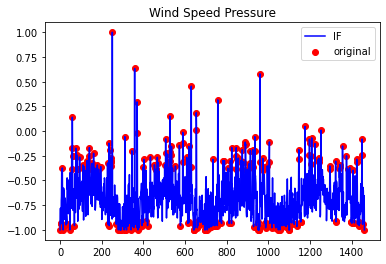

In [13]:
# mean preassure feature

dt_tr2 = [[item] for item in data_tr_sc[:,2]]

isolation_forest.fit(dt_tr2)
anomaly = isolation_forest.predict(dt_tr2)
res_list = [i for i in range(len(anomaly)) if anomaly[i] == -1]
print(res_list)
plt.title("Wind Speed Pressure")
plt.plot(dt_tr2,color='blue')

anomaly_val = []
for i in range(len(res_list)):
    anomaly_val.append(data_tr_sc[:,2][res_list[i]])
print(len(res_list))
print(len(anomaly_val))
plt.scatter(res_list,anomaly_val,color='r')
plt.legend(['IF', 'original'], loc='upper right')
plt.show()

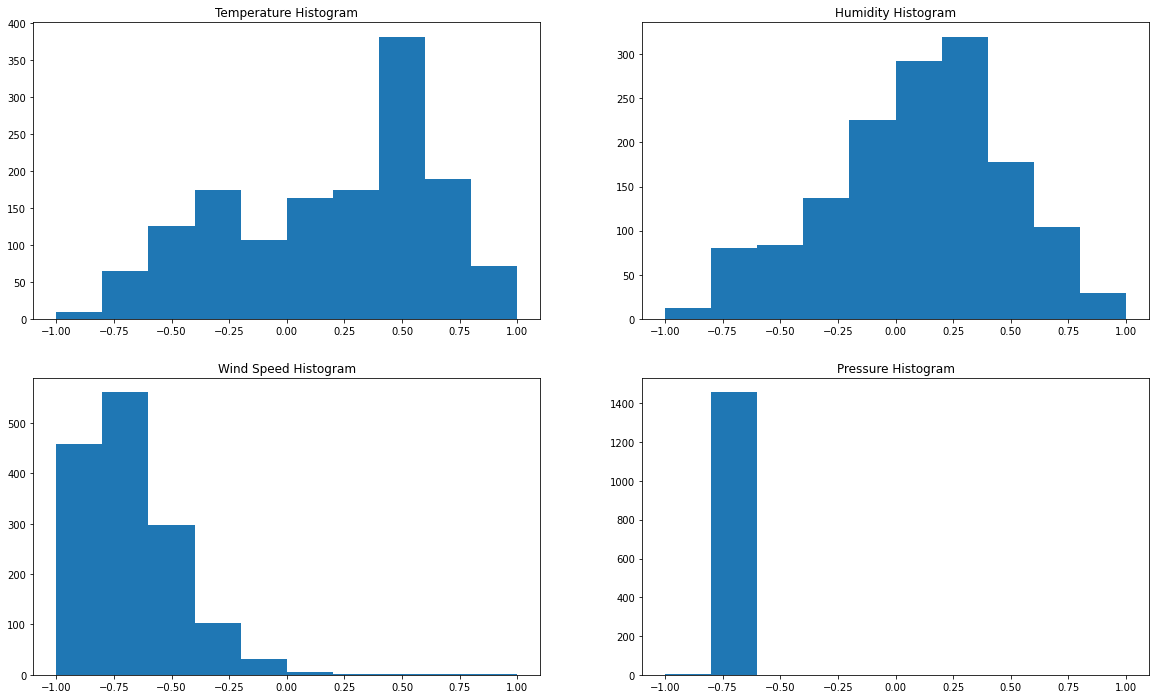

In [14]:
# statistical analysis
plt.rcParams['figure.figsize'] = (20, 12)
plt.subplot(2,2,1)
plt.hist(data_tr_sc[:,0])
plt.title("Temperature Histogram")
plt.subplot(2,2,2)

plt.hist(data_tr_sc[:,1])
plt.title("Humidity Histogram")
plt.subplot(2,2,3)
plt.hist(data_tr_sc[:,2])
plt.title("Wind Speed Histogram")
plt.subplot(2,2,4)
plt.hist(data_tr_sc[:,3])
plt.title("Pressure Histogram")
plt.show()

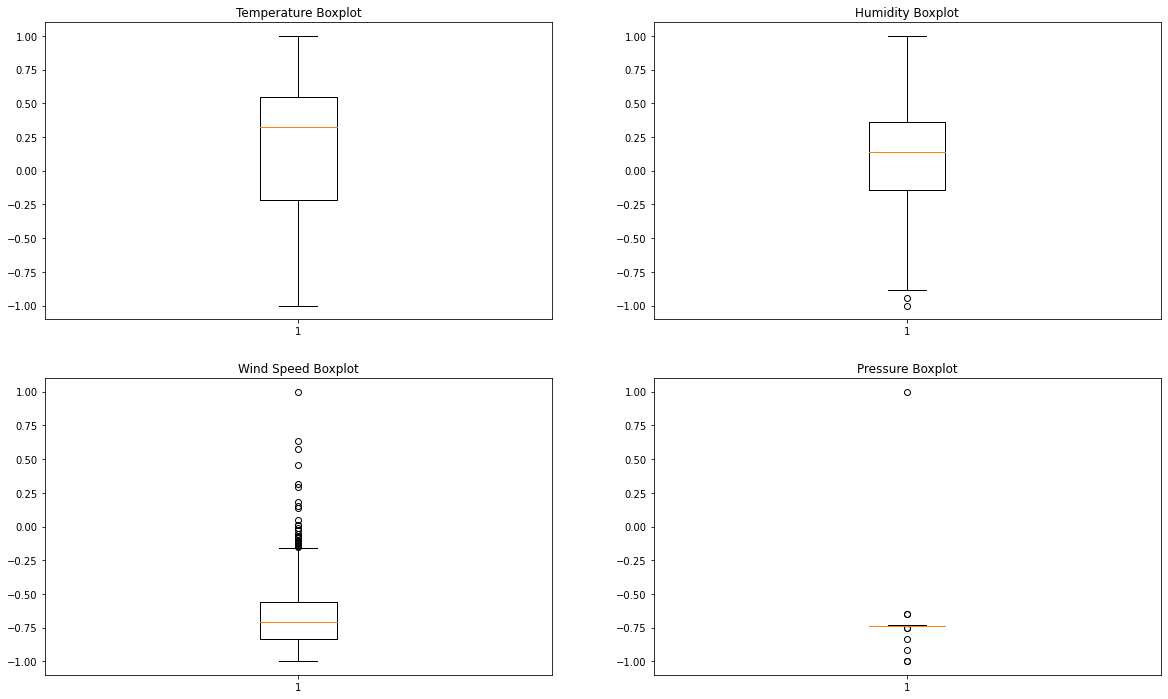

In [15]:
plt.subplot(2,2,1)
plt.boxplot(data_tr_sc[:,0])
plt.title("Temperature Boxplot")

plt.subplot(2,2,2)
plt.boxplot(data_tr_sc[:,1])
plt.title("Humidity Boxplot")

plt.subplot(2,2,3)
plt.boxplot(data_tr_sc[:,2])
plt.title("Wind Speed Boxplot")

plt.subplot(2,2,4)
plt.boxplot(data_tr_sc[:,3])
plt.title("Pressure Boxplot")
plt.show()

In [16]:
print(data_tr_sc)
print(type(data_tr_sc))
print(len(data_tr_sc))
print(data_tr_sc.shape)

[[-0.75545852  0.64191419 -1.         -0.73479339]
 [-0.91441048  0.81518152 -0.85883468 -0.734238  ]
 [-0.9286754   0.69966997 -0.78051476 -0.73401238]
 ...
 [-0.50509461  0.76127613 -0.70314227 -0.73421073]
 [-0.44656401  0.69966997 -0.65300805 -0.73468057]
 [-0.75545852  1.         -1.         -0.73470661]]
<class 'numpy.ndarray'>
1462
(1462, 4)


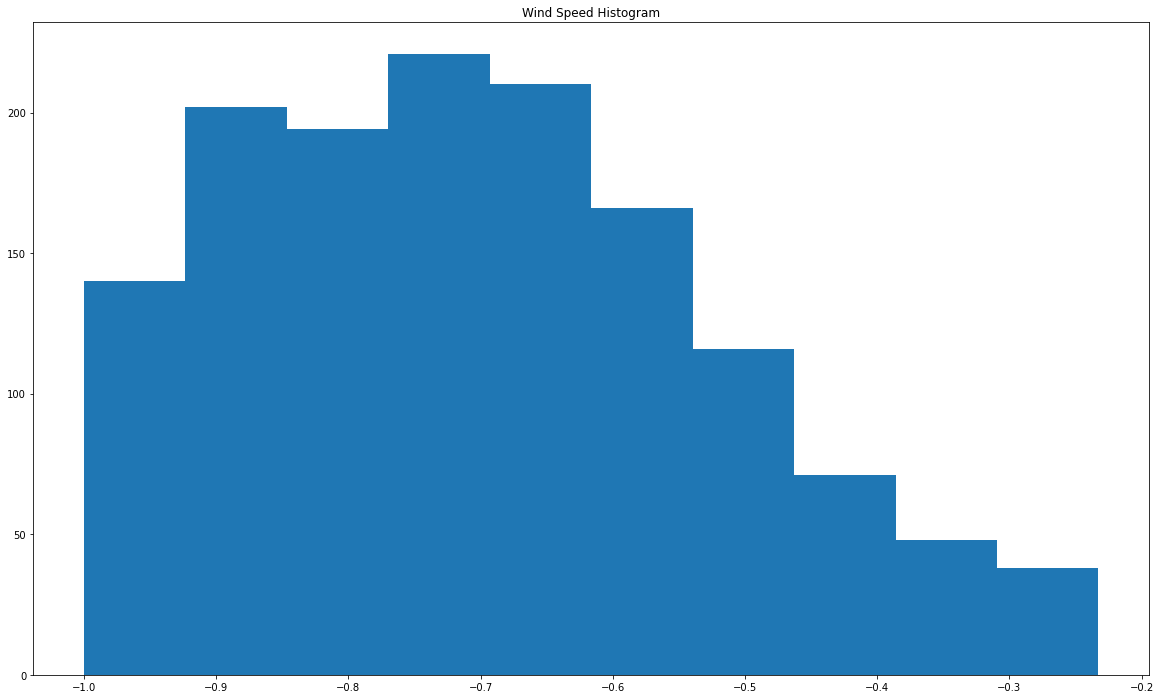

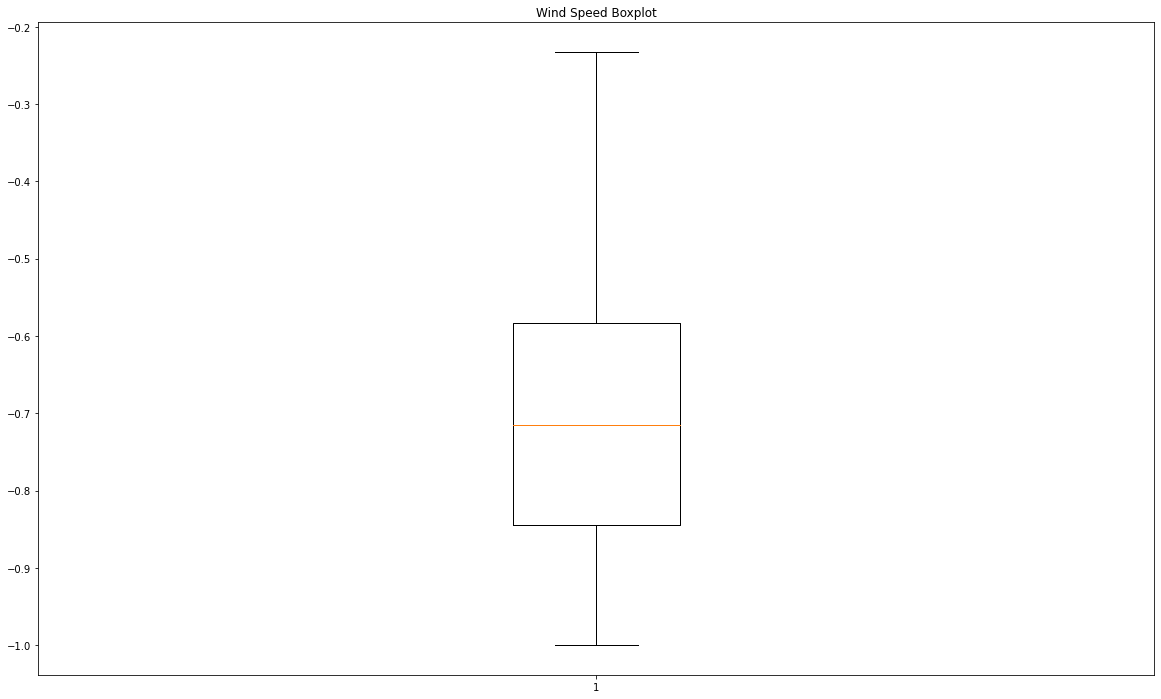

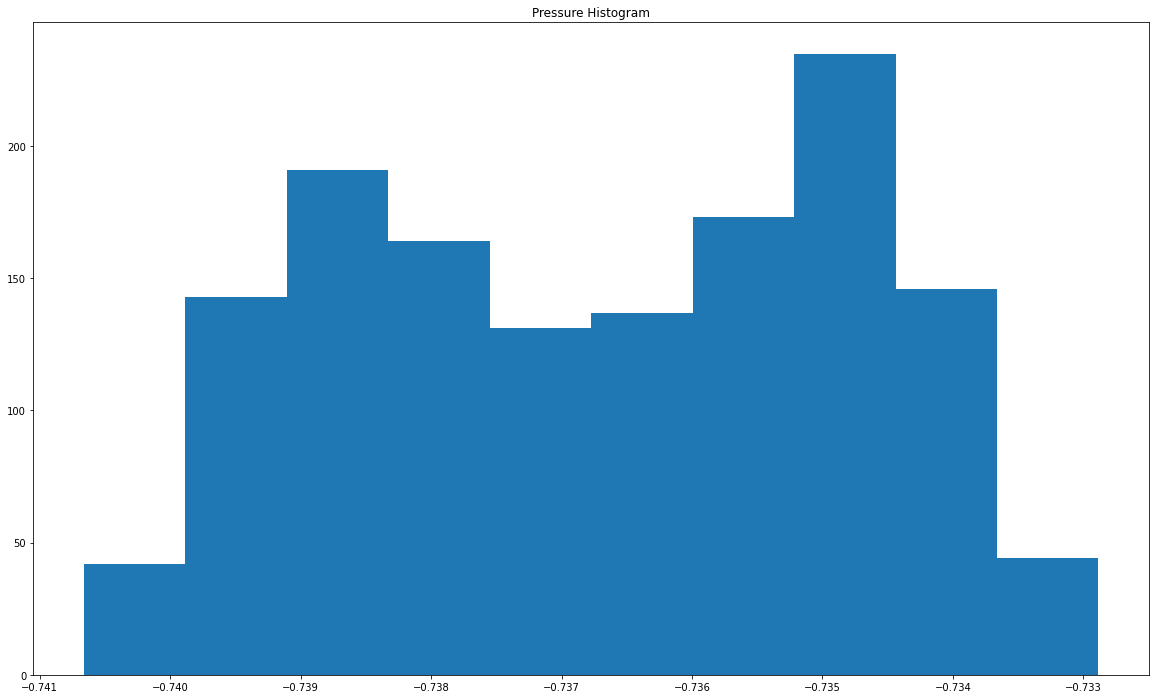

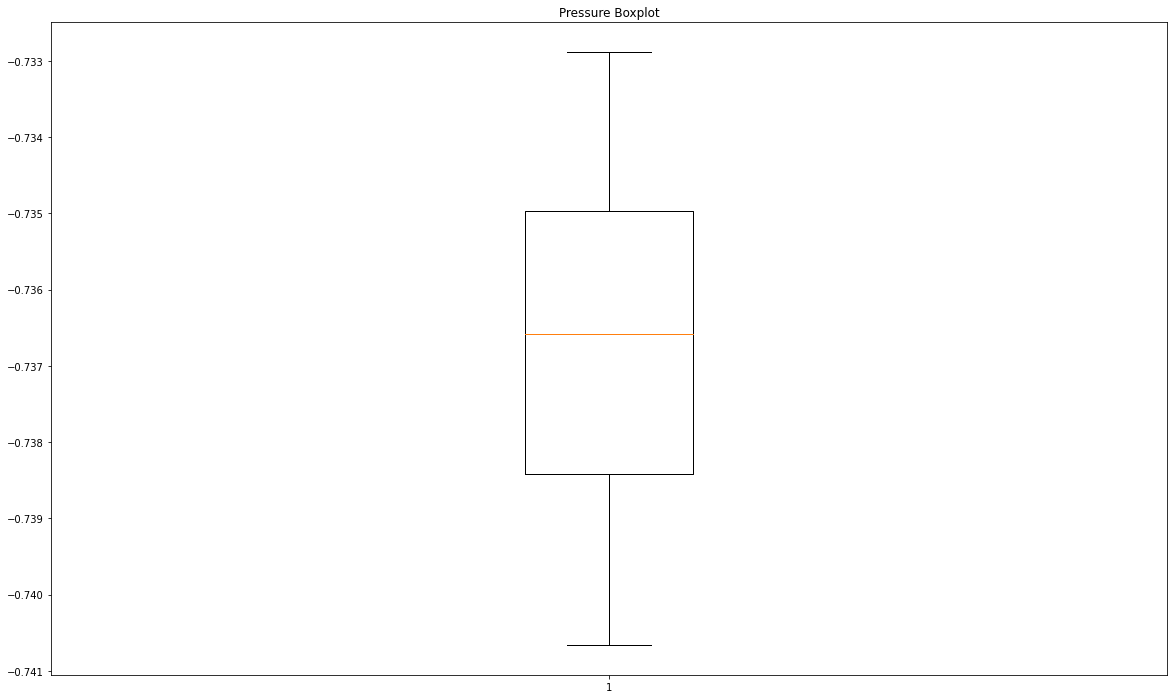

In [17]:
# calculating confidence interval
#wind speed
delete_row =[]
for i in range(data_tr_sc.shape[0]):
    if (-0.23)<data_tr_sc[i][2]:
#         data_tr_sc=np.delete(data_tr_sc,(i),axis=0)
        delete_row = np.append(delete_row,i)
#         print(data_tr_sc[i],i)
    elif (-0.72)<data_tr_sc[i][3] or (-0.75)>data_tr_sc[i][3]:
#         data_tr_sc=np.delete(data_tr_sc,(i),axis=0)
        delete_row = np.append(delete_row,i)
#         print(data_tr_sc[i],i)

data_tr_sc = np.delete(data_tr_sc,delete_row.astype(int),axis=0)
plt.hist(data_tr_sc[:,2])
plt.title("Wind Speed Histogram")
plt.show()
plt.boxplot(data_tr_sc[:,2])
plt.title("Wind Speed Boxplot")
plt.show()

#pressure
# for i in range(data_tr_sc.shape[0]):
#     if -0.72<data_tr_sc[i][3] or -0.75>data_tr_sc[i][3]:
#         data_tr_sc=np.delete(data_tr_sc,i,axis=0)
#         print(data_tr_sc[i],i)
plt.hist(data_tr_sc[:,3])
plt.title("Pressure Histogram")
plt.show()
plt.boxplot(data_tr_sc[:,3])
plt.title("Pressure Boxplot")
plt.show()

In [18]:
n_features = 4
n_months_in = 25
n_months_out = 2
X_train, y_train = split_sequences(data_tr_sc,n_months_in,n_months_out)
X_test, y_test = split_sequences(data_ts_sc,n_months_in,n_months_out)

In [19]:
# print(data_tr_sc[0:n_months_in+n_months_out,:])
# print("----------------------------------------------------")
# print(X_train[0,:])
# print("----------------------------------------------------")
# print(y_train[0,:])

In [20]:
# print(data_ts_sc[0:n_months_in+n_months_out,])
# print("----------------------------------------------------")
# print(X_test[0,])
# print("----------------------------------------------------")
# print( y_test[0,])

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1380, 25, 4)
(1380, 2, 4)
(88, 25, 4)
(88, 2, 4)


In [22]:
# reshape y values to 2D array
y_train = y_train.reshape(y_train.shape[0],n_months_out*n_features)
y_test = y_test.reshape(y_test.shape[0],n_months_out*n_features)
print(y_train.shape)
print(y_test.shape)

(1380, 8)
(88, 8)


In [33]:
# build LSTM model
# unit = 50-100-50 || dropout = 0.2-0.2 || epoch = 250 || val_split = 0.2
model = Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(n_months_in,n_features),kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.2)) # 20% neurons dropped out
model.add(LSTM(32,return_sequences=False,kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.2))
# model.add(LSTM(32))
# model.add(Dropout(0.3))
model.add(Dense(n_months_out*n_features))



In [129]:
# 4000(0.000005)+1000(0.0000001)+500(0.00000001)+500(0.000001)
# train the model 
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")
epochs = 300
validation_split = 0.3 # 20% validation set
history = model.fit(x=X_train, y=y_train, epochs=epochs,  verbose=1,validation_split=validation_split,shuffle=False)

Epoch 1/300
31/31 [==============================] - 11s 95ms/step - loss: 0.0214 - val_loss: 0.0194
Epoch 2/300
31/31 [==============================] - 1s 35ms/step - loss: 0.0209 - val_loss: 0.0194
Epoch 3/300
31/31 [==============================] - 1s 34ms/step - loss: 0.0210 - val_loss: 0.0194
Epoch 4/300
31/31 [==============================] - 1s 35ms/step - loss: 0.0213 - val_loss: 0.0194
Epoch 5/300
31/31 [==============================] - 1s 34ms/step - loss: 0.0208 - val_loss: 0.0194
Epoch 6/300
31/31 [==============================] - 1s 33ms/step - loss: 0.0207 - val_loss: 0.0195
Epoch 7/300
31/31 [==============================] - 1s 34ms/step - loss: 0.0208 - val_loss: 0.0193
Epoch 8/300
31/31 [==============================] - 1s 33ms/step - loss: 0.0211 - val_loss: 0.0193
Epoch 9/300
31/31 [==============================] - 1s 33ms/step - loss: 0.0209 - val_loss: 0.0195
Epoch 10/300
31/31 [==============================] - 1s 33ms/step - loss: 0.0211 - val_loss: 0.019

31/31 [==============================] - 1s 33ms/step - loss: 0.0209 - val_loss: 0.0195
Epoch 163/300
31/31 [==============================] - 1s 32ms/step - loss: 0.0205 - val_loss: 0.0194
Epoch 164/300
31/31 [==============================] - 1s 31ms/step - loss: 0.0203 - val_loss: 0.0196
Epoch 165/300
31/31 [==============================] - 1s 32ms/step - loss: 0.0206 - val_loss: 0.0195
Epoch 166/300
31/31 [==============================] - 1s 32ms/step - loss: 0.0205 - val_loss: 0.0196
Epoch 167/300
31/31 [==============================] - 1s 32ms/step - loss: 0.0204 - val_loss: 0.0195
Epoch 168/300
31/31 [==============================] - 1s 33ms/step - loss: 0.0205 - val_loss: 0.0195
Epoch 169/300
31/31 [==============================] - 1s 33ms/step - loss: 0.0206 - val_loss: 0.0194
Epoch 170/300
31/31 [==============================] - 1s 32ms/step - loss: 0.0204 - val_loss: 0.0195
Epoch 171/300
31/31 [==============================] - 1s 32ms/step - loss: 0.0206 - val_loss: 0

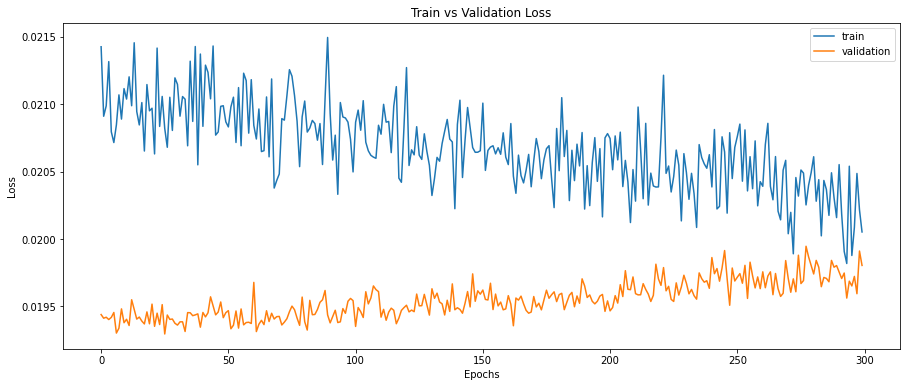

In [130]:
# plot the validation and training loss
plt.figure(figsize=(15,6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [131]:
# prediction step
y_pred = np.zeros((y_test.shape[0],y_test.shape[1]))
X_test_model = np.zeros((X_test[0].shape[0],X_test[0].shape[1]))
for i in range(X_test[0].shape[0]):
    for j in range(X_test[0].shape[1]):
        X_test_model[i][j] = X_test[0][i][j]

In [132]:
for i in range(X_test.shape[0]):
#     print("Before\n")
#     print(X_test_model)
    X_test_model = X_test_model.reshape(1,n_months_in,n_features)
    pred = model.predict(X_test_model, verbose=0)
    X_test_model.reshape(n_months_in,n_features)
#     print("Predicted\n")
#     print(pred)
#     print("Actual")
#     print(y_test[i])
    y_pred[i]=pred
#     print("-------------")
#     print(X_test_model[0,-1])
#     print(pred[0,0:n_features])
#     print("-------------")

    pred=pred.reshape(n_months_out,n_features)
#     print(pred)

    X_test_model[0,:-n_months_out] = X_test_model[0,n_months_out:]
    X_test_model[0,-n_months_out:] = pred
#     print("After")
#     print(X_test_model)
    


In [133]:
y_pred_inv = np.zeros((y_test.shape[0],y_test.shape[1]))
y_test_inv = np.zeros((y_test.shape[0],y_test.shape[1]))

y_test_inv[:,0] = inverse_transform(y_test[:,0],ts0_min,ts0_max)
y_pred_inv[:,0] = inverse_transform(y_pred[:,0],ts0_min,ts0_max)
y_test_inv[:,1] = inverse_transform(y_test[:,1],ts1_min,ts1_max)
y_pred_inv[:,1] = inverse_transform(y_pred[:,1],ts1_min,ts1_max)
y_test_inv[:,2] = inverse_transform(y_test[:,2],ts2_min,ts2_max)
y_pred_inv[:,2] = inverse_transform(y_pred[:,2],ts2_min,ts2_max)
y_test_inv[:,3] = inverse_transform(y_test[:,3],ts3_min,ts3_max)
y_pred_inv[:,3] = inverse_transform(y_pred[:,3],ts3_min,ts3_max)


rmse = mean_squared_error(y_test_inv, y_pred_inv) ** (0.5)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 291.624


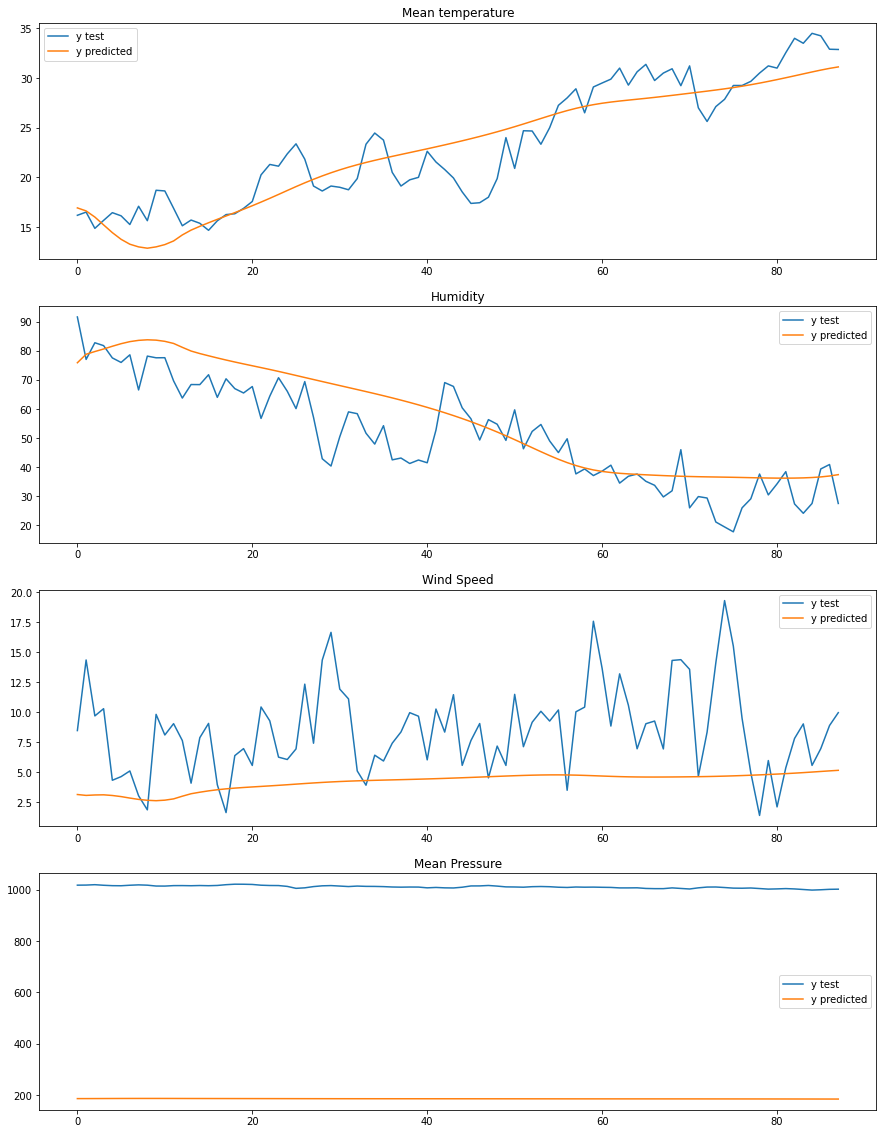

In [134]:
plt.figure(figsize=(15,5*4))

plt.subplot(4,1,1)
plt.title("Mean temperature")
plt.plot(y_test_inv[:,0])
plt.plot(y_pred_inv[:,0])
plt.legend(["y test","y predicted"])

plt.subplot(4,1,2)
plt.title("Humidity")
plt.plot(y_test_inv[:,1])
plt.plot(y_pred_inv[:,1])
plt.legend(["y test","y predicted"])

plt.subplot(4,1,3)
plt.title("Wind Speed")
plt.plot(y_test_inv[:,2])
plt.plot(y_pred_inv[:,2])
plt.legend(["y test","y predicted"])

plt.subplot(4,1,4)
plt.title("Mean Pressure")
plt.plot(y_test_inv[:,3])
plt.plot(y_pred_inv[:,3])
plt.legend(["y test","y predicted"])

plt.show()

In [135]:
print(y_test_inv[:,3])
print(y_pred_inv[:,3])

[1017.78571429 1018.125      1019.63636364 1017.38888889 1015.83333333
 1015.5        1017.5        1018.90909091 1017.72727273 1014.4
 1014.21052632 1016.         1016.125      1015.6        1016.375
 1015.66666667 1016.625      1019.625      1021.55555556 1021.375
 1020.57142857 1017.625      1016.5        1016.25       1013.
 1005.375      1007.41666667 1012.25       1015.25       1016.125
 1014.28571429 1012.375      1014.25       1013.11111111 1012.92307692
 1012.15       1010.625      1010.         1010.5        1010.33333333
 1007.375      1008.90909091 1007.35714286 1006.875      1009.8
 1014.75       1014.88888889 1016.55555556 1014.125      1011.1
 1010.7        1009.84615385 1011.88888889 1012.55555556 1011.75
 1009.75       1008.875      1010.58333333 1009.875      1010.2
 1009.5        1009.         1007.125      1007.14285714 1007.5
 1005.         1004.25       1004.25       1007.2        1005.
 1002.88888889 1007.375      1010.375      1010.625      1008.57142857
 1006.2

In [128]:
# print(y_test[:,3])
# print(y_pred[:,3])

In [32]:
# n_features = 4
# n_months_in = 10
# for n_months_out in range(2,10):
#     n_months_out = 2
#     X_train, y_train = split_sequences(data_tr_sc,n_months_in,n_months_out)
#     X_test, y_test = split_sequences(data_ts_sc,n_months_in,n_months_out)
    
#     y_train = y_train.reshape(y_train.shape[0],n_months_out*n_features)
#     y_test = y_test.reshape(y_test.shape[0],n_months_out*n_features)
    
#     model = Sequential()
#     model.add(LSTM(32,return_sequences=True,input_shape=(n_months_in,n_features),kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(0.2)) # 20% neurons dropped out
#     model.add(LSTM(64,return_sequences=False,kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(0.2))
#     # model.add(LSTM(32))
#     # model.add(Dropout(0.3))
#     model.add(Dense(n_months_out*n_features))

#     model.compile(optimizer=Adam(learning_rate=0.0000001), loss="mse")
#     epochs = 2500
#     validation_split = 0.3 # 20% validation set
#     history = model.fit(x=X_train, y=y_train, epochs=epochs,  verbose=0,validation_split=validation_split,shuffle=False)
    
#     plt.figure(figsize=(15,6))
#     plt.plot(history.history["loss"])
#     plt.plot(history.history["val_loss"])
#     plt.title("Train vs Validation Loss")
#     plt.ylabel("Loss")
#     plt.xlabel("Epochs")
#     plt.legend(['train', 'validation'], loc='upper right')
#     plt.show()
    
    
#     y_pred = np.zeros((y_test.shape[0],y_test.shape[1]))
#     X_test_model = np.zeros((X_test[0].shape[0],X_test[0].shape[1]))
#     for i in range(X_test[0].shape[0]):
#         for j in range(X_test[0].shape[1]):
#             X_test_model[i][j] = X_test[0][i][j]
            
#     for i in range(X_test.shape[0]):
#         X_test_model = X_test_model.reshape(1,n_months_in,n_features)
#         pred = model.predict(X_test_model, verbose=0)
#         X_test_model.reshape(n_months_in,n_features)
#         y_pred[i]=pred
#         pred=pred.reshape(n_months_out,n_features)
#         X_test_model[0,:-n_months_out] = X_test_model[0,n_months_out:]
#         X_test_model[0,-n_months_out:] = pred
    
#     y_pred_inv = np.zeros((y_test.shape[0],y_test.shape[1]))
#     y_test_inv = np.zeros((y_test.shape[0],y_test.shape[1]))

#     y_test_inv[:,0] = inverse_transform(y_test[:,0],ts0_min,ts0_max)
#     y_pred_inv[:,0] = inverse_transform(y_pred[:,0],ts0_min,ts0_max)
#     y_test_inv[:,1] = inverse_transform(y_test[:,1],ts1_min,ts1_max)
#     y_pred_inv[:,1] = inverse_transform(y_pred[:,1],ts1_min,ts1_max)
#     y_test_inv[:,2] = inverse_transform(y_test[:,2],ts2_min,ts2_max)
#     y_pred_inv[:,2] = inverse_transform(y_pred[:,2],ts2_min,ts2_max)
#     y_test_inv[:,3] = inverse_transform(y_test[:,3],ts3_min,ts3_max)
#     y_pred_inv[:,3] = inverse_transform(y_pred[:,3],ts3_min,ts3_max)


#     rmse = mean_squared_error(y_test_inv, y_pred_inv) ** (0.5)
#     print('Test RMSE: %.3f for n_months_out: %d' % rmse %n_months_out)
    
#     print('Plots for n_months_out: %d' %n_months_out)
#     plt.figure(figsize=(15,5*4))
#     plt.subplot(4,1,1)
#     plt.title("Mean temperature")
#     plt.plot(y_test_inv[:,0])
#     plt.plot(y_pred_inv[:,0])
#     plt.legend(["y test","y predicted"])
    
#     plt.subplot(4,1,2)
#     plt.title("Humidity")
#     plt.plot(y_test_inv[:,1])
#     plt.plot(y_pred_inv[:,1])
#     plt.legend(["y test","y predicted"])

#     plt.subplot(4,1,3)
#     plt.title("Wind Speed")
#     plt.plot(y_test_inv[:,2])
#     plt.plot(y_pred_inv[:,2])
#     plt.legend(["y test","y predicted"])

#     plt.subplot(4,1,4)
#     plt.title("Mean Pressure")
#     plt.plot(y_test_inv[:,3])
#     plt.plot(y_pred_inv[:,3])
#     plt.legend(["y test","y predicted"])

#     plt.show()